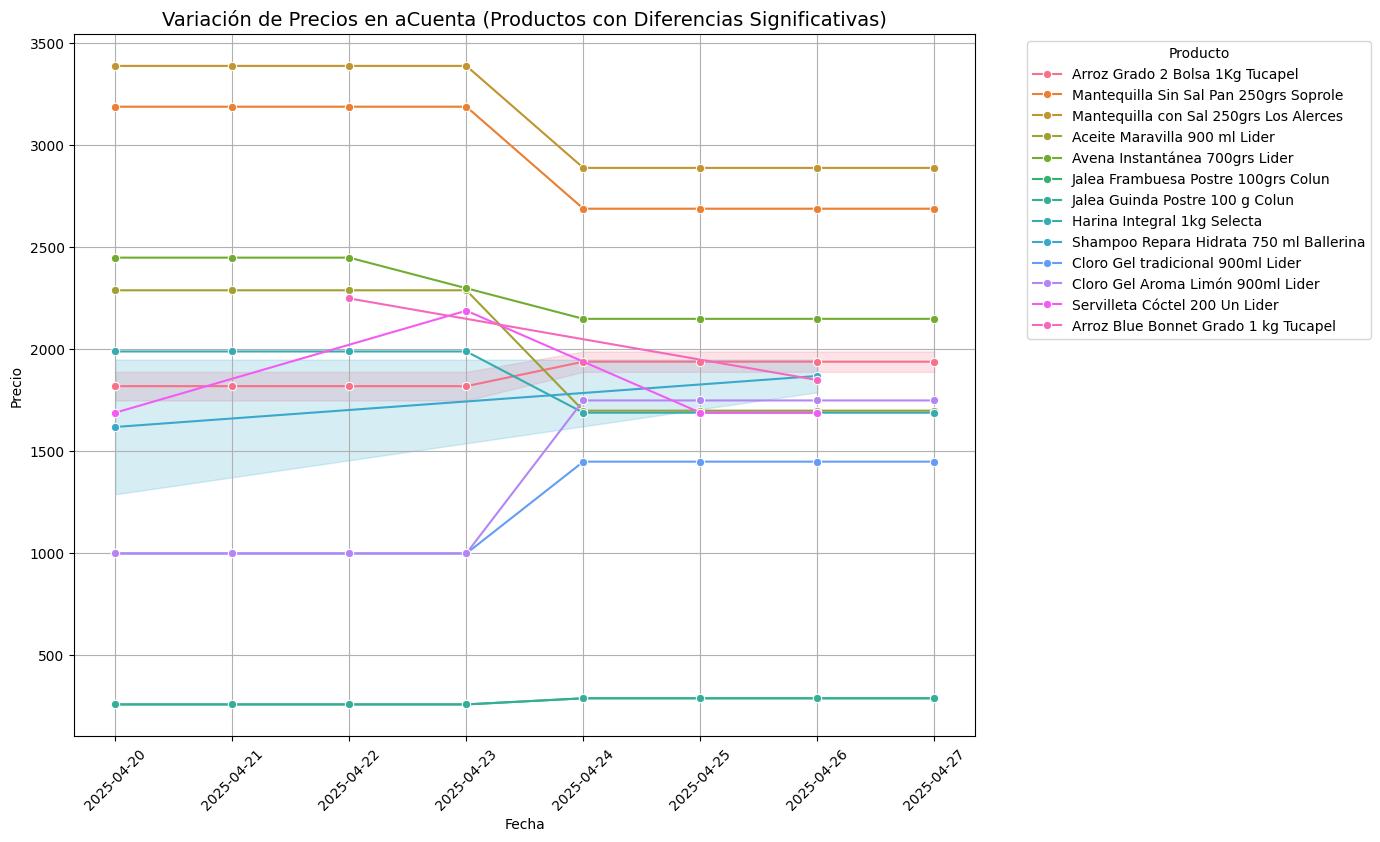

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

data_frames = []

for child in Path('../../utils/common-products-filter/results/').iterdir():
    if child.is_file():
        data = pd.read_csv(child)

        df_acuenta = data[['acuenta', 'price_acuenta']].copy()
        df_acuenta['date'] = datetime.strptime(child.name.replace(".csv", ""), "%d-%m-%Y").date()
        data_frames.append(df_acuenta)

df = pd.concat(data_frames, ignore_index=True)
df = df.dropna(subset=['price_acuenta', 'date'])

# Agrupar por producto y calcular estadísticas
estadisticas = df.groupby('acuenta')['price_acuenta'].agg(['min', 'max', 'mean', 'std', 'count']).reset_index()
estadisticas['Diferencia Absoluta'] = estadisticas['max'] - estadisticas['min']
estadisticas['Diferencia Relativa (%)'] = (estadisticas['Diferencia Absoluta'] / estadisticas['mean']) * 100

# Filtrar productos con diferencias significativas
productos_significativos = estadisticas[
    (estadisticas['Diferencia Absoluta'] > 300) | 
    (estadisticas['Diferencia Relativa (%)'] > 10)
]['acuenta']

# Filtrar el DataFrame original para solo esos productos
df_filtrado = df[df['acuenta'].isin(productos_significativos)]

# Gráfico
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_filtrado, x='date', y='price_acuenta', hue='acuenta', marker="o")

plt.title("Variación de Precios en aCuenta (Productos con Diferencias Significativas)", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend(title='Producto', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.xticks(rotation=45)
plt.savefig('price-variation-acuenta.png', bbox_inches='tight')
plt.show()